# Support Vector Machine

Support vector machine(SVM) is a popular classification algorithm widely used in machine learning. Suppose there exist two labels, $-1$ and $1$, for all data samples. The task of SVM is to find parameters $\textbf{a}$ and $b$ such that given a feature vector $\textbf{x}_{i}$, $\space\textbf{a}^T\textbf{x}_{i} + b$ has the same sign as the true label $y_{i}$. To achieve this goal, it is important to define a loss function:

$L = max(0, \space1-y_{i}(\textbf{a}^T\textbf{x}_{i} + b))$

which is known as the hinge loss. The function has three important properties:

$\bullet$ If $y_{i}$ and $\textbf{a}^T\textbf{x}_{i} + b$ have different sign, then $L$ should be large because the prediction is wrong.

$\bullet$ If $y_{i}$ and $\textbf{a}^T\textbf{x}_{i} + b$ have the same sign but $y_{i}(\textbf{a}^T\textbf{x}_{i} + b)<1$, then $\textbf{x}_{i}$ is closer to the decision boundary, so the loss is small because we want to discourge this.

$\bullet$ If $y_{i}$ and $\textbf{a}^T\textbf{x}_{i} + b$ have the same sign but $y_{i}(\textbf{a}^T\textbf{x}_{i} + b)>=1$, then the predictor is doing a good job and there is no loss.

Though the hinge loss function is useful in reflecting different results in classfication, it fails in guaranteeing the uniqueness of $\textbf{a}$ since we can always multiply the parameter pair by some constant and get the same result. To compensate this, we introduce regularizer that has the form of:

$\lambda\frac{\textbf{a}\textbf{a}^{T}}{2}$

where $\lambda$ is the regularization factor and is usually determined by trying different numbers. So the regularized loss function over all data becomes:

$L = \frac{1}{N}\sum\limits_{i=0}^{N} max(0, \space1-y_{i}(\textbf{a}^T\textbf{x}_{i} + b)) + \lambda\frac{\textbf{a}\textbf{a}^{T}}{2}$

In practice, it is common to use Stochastic Gradient Descent(SGD) to train the model batch by batch. Taking the gradient of the loss function with respect to $\textbf{a}$ and $b$ gives:

$\textbf{a}^{n+1} = \textbf{a}^{n} - \eta * \left\{\begin{matrix}
\lambda\textbf{a}, \space\space\space y_{i}(\textbf{a}^T\textbf{x}_{i} + b) >= 1\\
\lambda\textbf{a} - y_{i}\textbf{x}_{i}, \space\space\space otherwise
\end{matrix}\right.$

and

$b^{n+1} = b^{n} - \eta * \left\{\begin{matrix}
0, \space\space\space y_{i}(\textbf{a}^T\textbf{x}_{i} + b) >= 1\\
-y_{i}, \space\space\space otherwise
\end{matrix}\right.$

where $\eta$ is the step length that measures how much the parameter pair should move toward the direction of the descending gradient and is defined as:

$\eta = \frac{m}{e + n}$

where $m$ and $n$ are constants determined in practice and $e$ is the training times. Notice that the step decreases as the number of trained epochs increases. This example will show how SVM predicts whether the annual income of an adult is higher than 50K.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('train.csv', header=None).values
data[np.where(data == ' <=50K')] = -1
data[np.where(data == ' >50K')] = 1
data = data[:, [0,2,4,10,11,12,-1]]# only use numerical features and the last column(label)
mean = np.mean(data[:, 0:-1], axis=0)
std = np.std(data[:, 0:-1].astype(int), axis=0)
split = int(0.9*data.shape[0]) 

# data unit normalization
data[:, 0:-1] = np.divide(np.subtract(data[:, 0:-1], mean), std)

lambdas = np.array([0.001, 0.01, 0.1, 1])
train_acc = np.ones((4, 10))
test_acc = np.ones((4, 1))

# train and evaluate model for different lambdas
for i in range(4): 
    
    best_acc = 0
    for epo in range(50): # train the model for 50 epochs

        # randomly split the data set into 90% training and 10% testing
        rand_idx = np.arange(data.shape[0])
        np.random.shuffle(rand_idx)
        train = data[rand_idx[0:split]]
        test = data[rand_idx[split:]]

        # select a small portion of training data as held out and the rest to be epoch dataset
        held_out = train[0:50]
        epoch = train[50:]
        steps = 300
        batch_size = int(epoch.shape[0]/steps) # batch_size = epoch_size / step
        held_out_acc = []
        
        # initialize a and b
        a = np.ones((1,6))
        b = 1
        
        for s in range(steps):
            
            step_length = 1/(0.01*s+20)# variant step length
            batch = epoch[ s*batch_size : (s+1)*batch_size ]
            boundary = np.dot(batch[:,-1].T, (np.dot(batch[:, 0:-1], a.T) + b))# y*(a*x+b)
            if boundary >= 1:
                a = a - step_length * lambdas[i] * a
            else:
                a = a - step_length * (lambdas[i] * a - batch[-1, -1] * batch[-1, 0:-1])
                b = b + step_length * batch[-1, -1]
                
            if s % 30 == 0: # examine the model accuracy on held out data for every 30 steps
                held_out_pred = np.sign(np.dot(held_out[:, 0:-1], a.T) + b)
                held_out_err = np.where(held_out_pred.T != held_out[:, -1])[0].shape[0]
                held_out_acc = 1 - held_out_err / held_out.shape[0]
                mark = int(s/30)
                train_acc[i, mark] = held_out_acc
                
        pred = np.sign(np.dot(test[:, 0:-1], a.T) + b)
        err = np.where(pred.T != test[:, -1])[0].shape[0]
        acc = 1 - err / test.shape[0]        
        if acc > best_acc:
            best_acc = acc
            
    test_acc[i] = best_acc

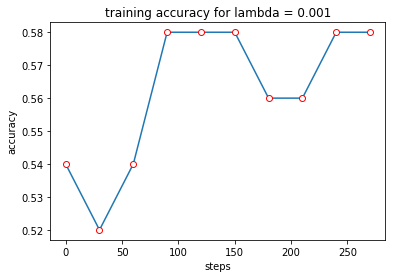

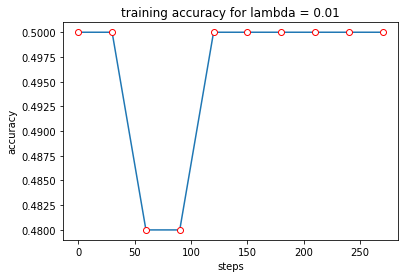

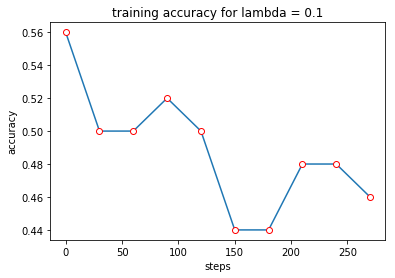

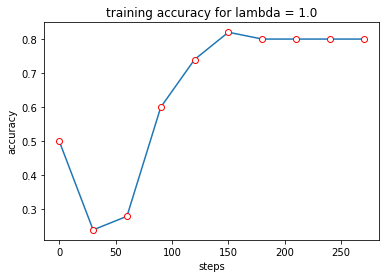

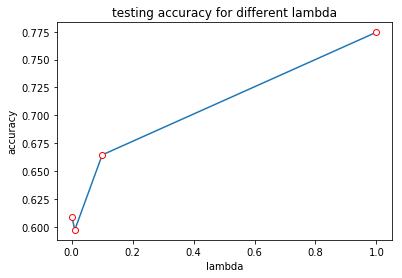

In [3]:
# plot accuracy plots for different lambda values

x = np.linspace(0, 270, num = 10)
y1 = train_acc
y2 = test_acc
for i in range(4):   
    plt.figure()
    plt.plot(x, y1[i], marker='o', mec='r', mfc='w')
    plt.title('training accuracy for lambda = ' + str(lambdas[i]))
    plt.xlabel('steps')
    plt.ylabel('accuracy') 
    plt.show()
     
plt.figure()
plt.plot(lambdas, y2, marker='o', mec='r', mfc='w')
plt.title('testing accuracy for different lambda')
plt.xlabel('lambda')
plt.ylabel('accuracy') 
plt.show()